# Diversity and Variation In Class Exercise
Module: Introduction to BIOL 1435 & Evolutionary Genetics \
Topic: Describing variation and patterns of diversity.

In [1]:
# Import modules.
import demes
import demesdraw
from matplotlib import pyplot as plt
import math
import msprime
import numpy as np
import pandas as pd
import scipy
#import toyplot
# Print versions.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)
print('scipy', scipy.__version__)
#print('toyplot', toyplot.__version__)

demes 0.2.3
demesdraw 0.4.0
msprime 1.3.3
numpy 1.26.4
scipy 1.13.1


First, lets initialize the genotype matrix we'll be using for this exercise.

In [2]:
# Intialize the example matrix,
# which has a shape of 5 sites x 5 chromosomes.
geno_mat = np.array([
    [0, 0, 0, 0, 1],
    [0, 1, 1, 0, 1],
    [0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
])
# Double check the dimensions.
print(
    f'The genotype matrix has genotype information for {geno_mat.shape[1]}'
    f' haploid individuals across {geno_mat.shape[0]} sites.'
)
# Show the genotype matrix.
geno_mat

The genotype matrix has genotype information for 5 haploid individuals across 6 sites.


array([[0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [4]:
num_der = np.sum(geno_mat, axis=1)
print(num_der)
seg_site = 0

# for a GENOtype matrix 2N, 

for count in num_der:
    if count != 0 and count != geno_mat.shape[1]: # *2 for diploid GENOtype
        seg_site += 1

print(seg_site)

[1 3 3 1 5 5]
4


To check the dimensions we use the `<numpy_array>.shape` which returns a tuple where the first entry corresponds to the size of the first dimension and the second entry corresponds to the size of the second dimension etc etc.

__Gene Diversity ($h$ & $H$)__ \
\
$h = 1 - \left(p^{2} + q^{2} \right)$ \
$H = \frac{1}{L} \sum_{j = 1}^{L} h_j$

Variables:
- $p$ is the frequency of the derived/alternate allele
- $q = \left(1 - p \right)$ which is the frequency of the ancestral/reference allele
- $h_j$ is the gene diversity for site $j$ and $L$ is the total number of sites

First, let's calculate the derived allele frequency per site.

In [4]:
# Calculate the derived allele frequency.
der_freqs = np.sum(geno_mat, axis=1) / geno_mat.shape[1]
# Show the derived allele frequency array.
der_freqs

array([0.2, 0.6, 0.6, 0.2, 1. , 1. ])

Note that the `axis=1` in `np.sum(geno_mat, axis=1)` means for each row (site) we sum all the entries along the columns (chromosomes) similarly the `.shape[1]` in  `geno_mat.shape[1]` means to extract the number of columns (aka extract the number of chromosomes).

Now, that we have our derived allele frequency array let's calculate gene diversity per site.

In [5]:
# Calculate gene diversity for site.
h = 1 - ((der_freqs ** 2) + ((1 - der_freqs) ** 2))
# Show the per site gene diversity array.
h

array([0.32, 0.48, 0.48, 0.32, 0.  , 0.  ])

Now, let's calculate the overall gene diversity for our genotype matrix.

In [7]:
# Calculate gene diversity for the genotype matrix.
H = round(np.sum(h) / h.size, 5)
# Show the overall gene diversity for the genotype matrix.
H

0.26667

Note that `np.sum(h) / h.size` will return `0.31999999999999995` which is a rounding error due to how floating point math works, which you can read more about [here](https://docs.python.org/3/tutorial/floatingpoint.html), but for most things we will do in the class rounding to five decimal places will be sufficient.

However, it is not good practice to hardcode things like we did so here is an example of a function to do the same work we just did, but for an arbitrary genotype matrix.

In [8]:
# Define a function to calculate gene diversity per site.
def gene_diversity(genotype_matrix):
    """Returns an of array gene diversity per site.
    
    genotype_matrix -- numpy matrix with a shape of (sites x chromosomes).
    """
    # Determine the frequency of the alternative/derived allele per site.
    frequency_array = np.sum(genotype_matrix, axis=1) / genotype_matrix.shape[1]
    # Calculate the per site gene diversity.
    per_site_h = 1 - ((frequency_array ** 2) + ((1 - frequency_array) ** 2))
    return per_site_h

In [9]:
# Calculate per site gene diversity.
new_h = gene_diversity(geno_mat)
# Show the per site gene diversity.
new_h

array([0.32, 0.48, 0.48, 0.32, 0.  , 0.  ])

In [10]:
# Calculate the average gene diversity for this locus.
new_H = round(new_h.sum() / new_h.size, 5)
# Show the average gene diversity for this locus.
new_H

0.26667

__Nucleotide Diversity ($\Pi$ & $\pi$)__ \
\
$\Pi = \frac{\sum_{i < j} k_{ij}}{\binom{n}{2}}$ \
$\pi = \frac{\Pi}{L}$

Variables:
- $k_{ij}$ is the number of nucleotide differences between the $i^{th}$ and $j^{th}$ sample
- $n$ the number of chromosomes
- $L$ is to the total number of sites

First, we will calculate the number of pairwise differences.

In [11]:
# Intialize a variable to store the number of pairwise differences.
pw_diff = 0
# For every sequence...
for i in range(geno_mat.shape[1]):
    # For every other sequence we haven't compared sequence i to...
    for j in range(i+1, geno_mat.shape[1]):
        # Update the total number of pairwise differences.
        pw_diff += np.count_nonzero((geno_mat[:, i] != geno_mat[:, j]))
# Show the total number of pairwise differnces.
pw_diff

20

Now, let's calculate 5 choose 2 and our average nucleotide diversity.

In [12]:
# Calculate 5C2 .
five_choose_two = (geno_mat.shape[1] * (geno_mat.shape[1] - 1)) / 2
# Calculate the average nucleotide diversity.
Pi = pw_diff / five_choose_two
# Show the average nucleotide diversity.
Pi

2.0

Lastly calculate the average nucleotide diversity per site.

In [13]:
# Calculate the average nucleotide diversity per site.
pi = Pi / geno_mat.shape[0]
# Show the average nucleotide diversity per site.
pi

0.3333333333333333

Similarly to before, it is not good practice to hard code these equations. Additionally, `for` loops can be quite time consuming when the number of sampled chromosomes increases. So here is a function to calculate nucleotide diversity per site using a different implementation than what we did above.

In [14]:
# Define a function to calculate nucleotide diversity per site.
def nucleotide_diversity(genotype_matrix):
    """Returns an of array nucleotide diversity per site.
    
    genotype_matrix -- numpy matrix with a shape of (sites x chromosomes).
    """
    # Calculate nC2 .
    n_choose_2 = (genotype_matrix.shape[1] * (genotype_matrix.shape[1] - 1)) / 2
    # Determine the allele counts of the derived/alternative allele.
    derived_allele_count = genotype_matrix.sum(axis=1)
    # Determine the allele counts of the ancestral/reference allele.
    ancestral_allele_count = genotype_matrix.shape[1] - derived_allele_count
    # Calculate the per site nucleotide diversity.
    per_site_pi = (derived_allele_count * ancestral_allele_count) / n_choose_2
    return per_site_pi

In [15]:
# Calculate nucleotide diversity per site.
Pi_per_site = nucleotide_diversity(geno_mat)
# Show the per site nucleotide diversity.
Pi_per_site

array([0.4, 0.6, 0.6, 0.4, 0. , 0. ])

In [16]:
# Show the number of pairwise differences per site.
Pi_per_site * five_choose_two

array([4., 6., 6., 4., 0., 0.])

In [17]:
# Calculate the average nucleotide diversity per site.
new_pi = np.mean(Pi_per_site)
# Show the average nucleotide diversity per site.
new_pi

0.3333333333333333

__Segregating sites ($S$)__

In class we touched on why segregating sites may not be the best metric for summarizing diversity. Here I use the simulation software `msprime` to simulate a 100 kb sequence from a single population with an effective population size of 10,000. I then run each simulation 1,000 times per sample size, record the number of segregating sites for each simulation, and the find the mean number of segregating sites for each sample size. Walk through this code, play around and convince yourself that this explanation is true. 

In [18]:
# Intialize an array of sample sizes.
N = np.array([100, 200, 300, 400, 500])
# Define the number of replicate simulations to run.
n_reps = 1_000
# Intialize an empty array to store the results.
sim_mean_seg_sites = np.array([])
# For every sample size...
for sample_size in N:
    # Intialize an empty list to store results.
    seg_sites = []
    # For every tree-sequence...
    for ts in msprime.sim_ancestry(
        samples=sample_size,
        ploidy=1,
        sequence_length=100_000,
        population_size=10_000,
        discrete_genome=False,
        num_replicates=n_reps,
    ):
        # Overlay mutations on the tree-sequence.
        mts = msprime.sim_mutations(
            tree_sequence=ts, rate=1.5 * 10**-8,
            model='jc69',
            discrete_genome=False,
        )
        # Append the results with the number of segregating sites. 
        seg_sites.append(mts.genotype_matrix().shape[0])
    # Append the mean number of segregating sites from 1000 simulations.
    sim_mean_seg_sites = np.append(sim_mean_seg_sites, np.mean(np.array(seg_sites)))

Now, that we have run our simulations we will plot the relationship between the sample size and number of segregating sites. What do you think this realationship will look like?

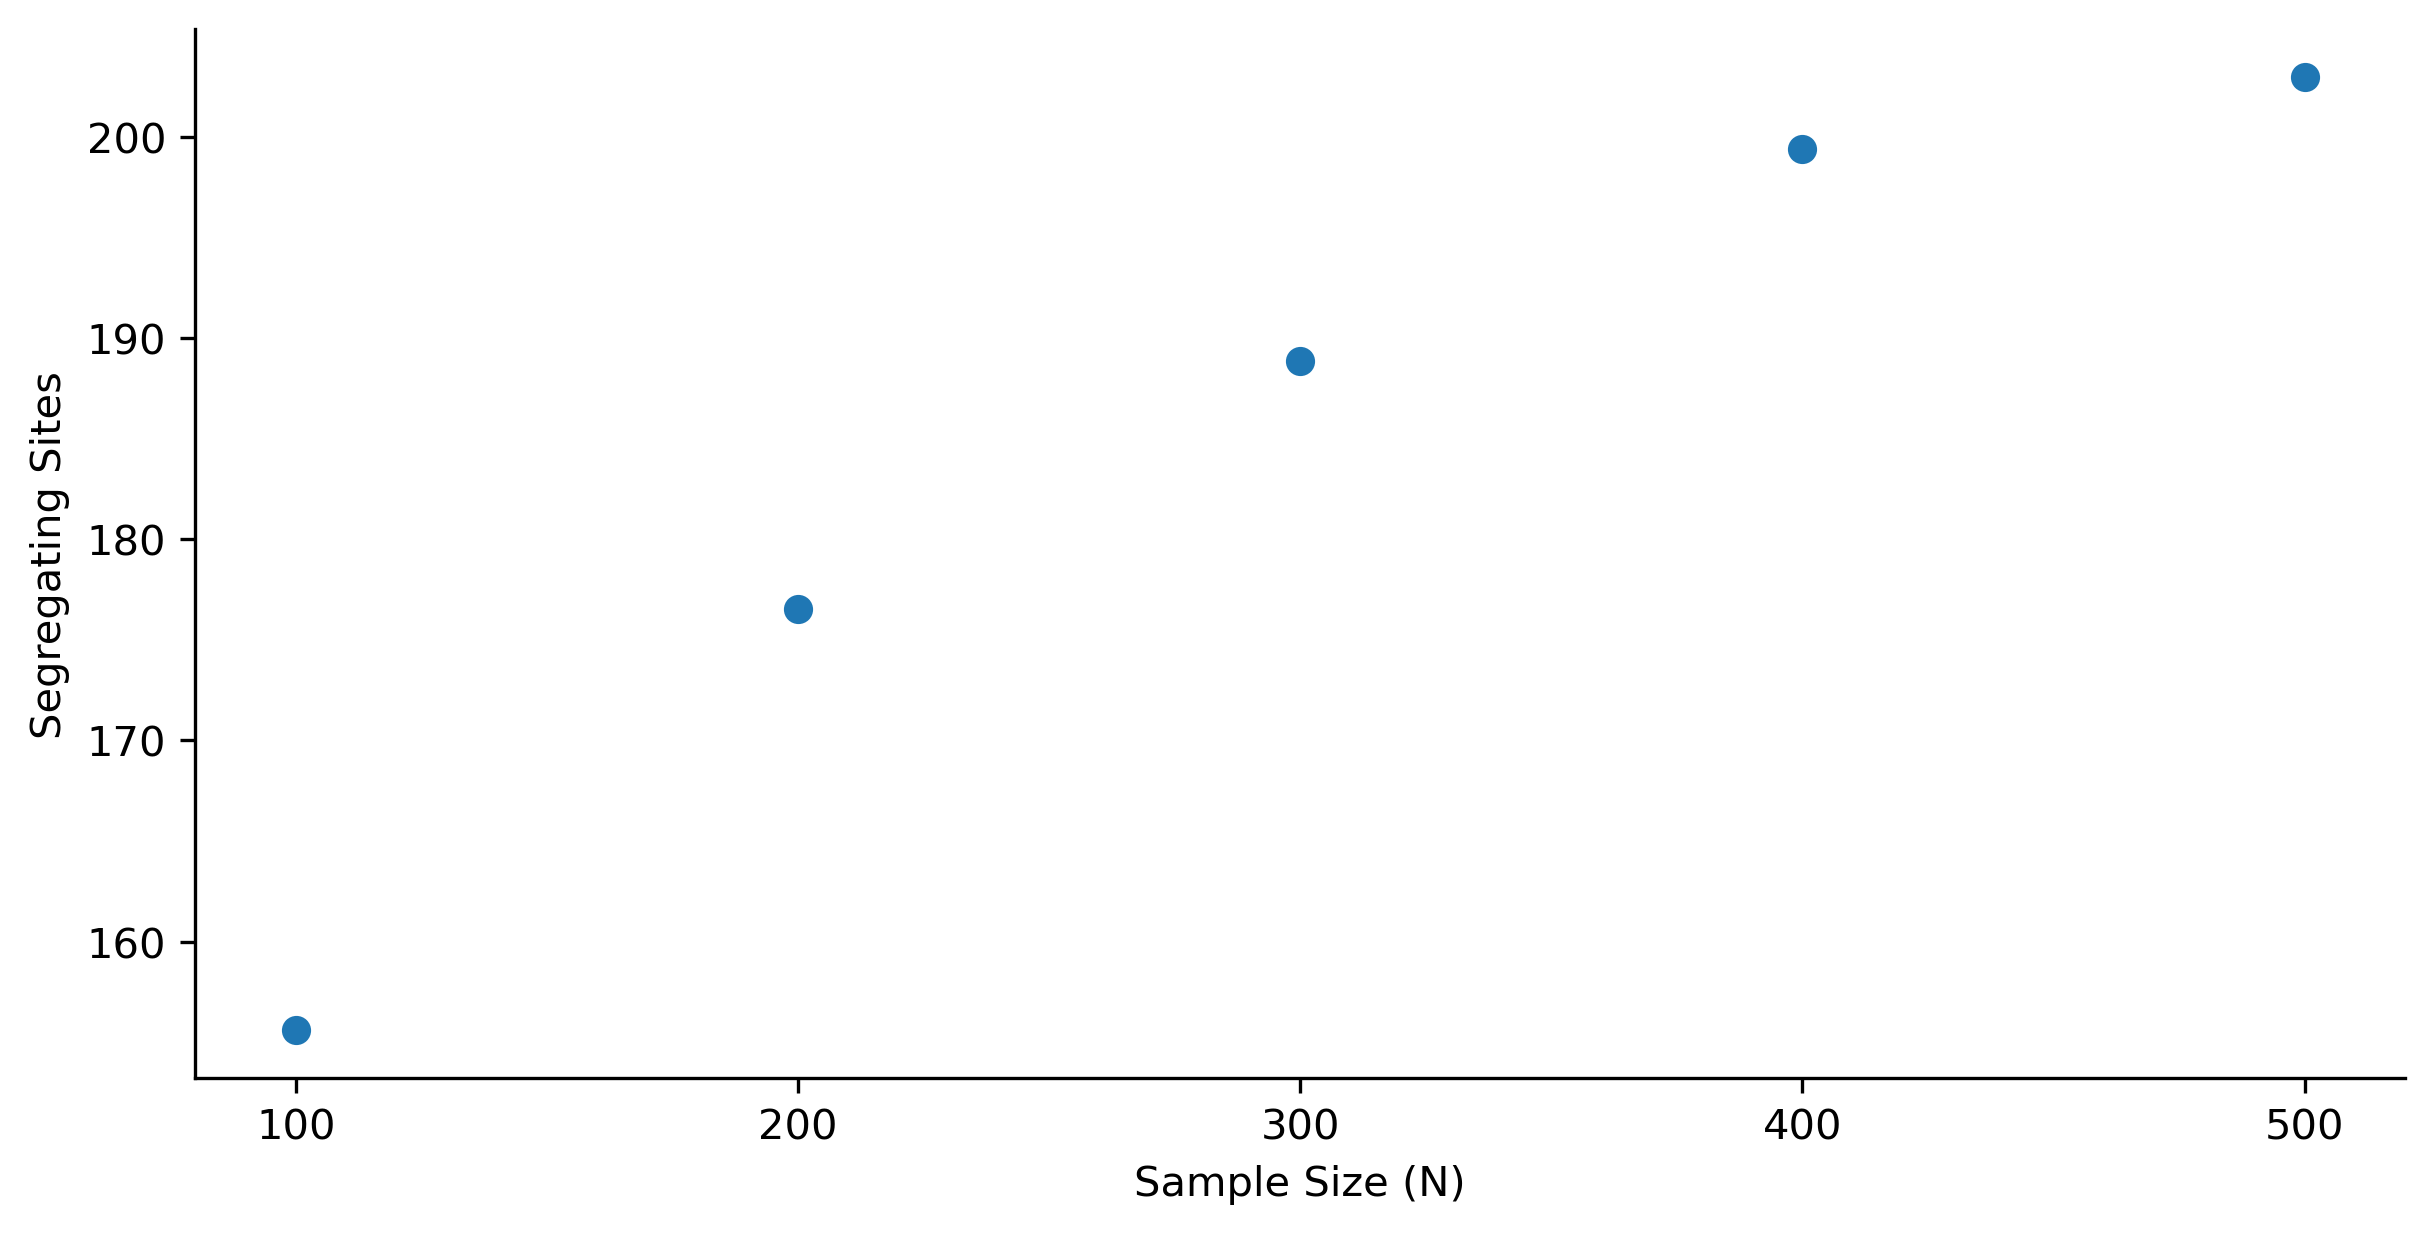

In [19]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the simulated results.
ax.scatter(N, sim_mean_seg_sites)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Label the x-axis ticks.
ax.set_xticks(N)
ax.set_xticklabels(N)
# Label the axes.
plt.xlabel('Sample Size (N)')
plt.ylabel('Segregating Sites')
# Show!
plt.show()

Does this relationship make sense? If not, ask for help!

__The Site Frequency Spectrum (SFS)__

So from lecture we learned that the SFS is essentially a histogram summary of the frequency of variants—for our purposes here the derived allele—and from the readings we have some idea of what patterns of diversity should look like in contemporary human populations. Below I defined the three population Out-of-Africa model from Gutenkunst et al. 2009, which is one of the go to models in human population genetics. Look through the code below and the output of the demography debugger to see if this makes sense to you.

In [20]:
# Intialize the generation time.
generation_time = 25
# Times are provided in years, so we convert into generations.
T_OOA = 21.2e3 / generation_time
T_AMH = 140e3 / generation_time
T_ANC = 220e3 / generation_time
# We need to work out the starting population sizes based on
# the growth rates provided for these populations.
r_CEU = 0.004
r_CHB = 0.0055
N_CEU = 1000 / math.exp(-r_CEU * T_OOA)
N_CHB = 510 / math.exp(-r_CHB * T_OOA)
N_AFR = 12300
# Intialize an instance of demography.
demography = msprime.Demography()
# Intialize the YRI population.
demography.add_population(
    name='YRI',
    description='Yoruba in Ibadan, Nigeria',
    initial_size=N_AFR,
)
# Intialize the CEU population.
demography.add_population(
    name='CEU',
    description=(
        'Utah Residents (CEPH) with Northern and Western European Ancestry'
    ),
    initial_size=N_CEU,
    growth_rate=r_CEU,
)
# Intialize the CHB population.
demography.add_population(
    name='CHB',
    description='Han Chinese in Beijing, China',
    initial_size=N_CHB,
    growth_rate=r_CHB,
)
# Intialize the OOA population.
demography.add_population(
    name='OOA',
    description='Bottleneck out-of-Africa population',
    initial_size=2100,
)
# Intialize the AMH population.
demography.add_population(
    name='AMH', description='Anatomically modern humans', initial_size=N_AFR
)
# Intialize the ANC population.
demography.add_population(
    name='ANC',
    description='Ancestral equilibrium population',
    initial_size=7300,
)
# CEU and CHB originate from OOA.
demography.add_population_split(time=T_OOA, derived=['CEU', 'CHB'], ancestral='OOA')
# Adjust the migration rate change.
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=['YRI', 'OOA'], rate=25e-5
)
# YRI and OOA originate from AMH.
demography.add_population_split(time=T_AMH, derived=['YRI', 'OOA'], ancestral='AMH')
# AMH originaes from ANC.
demography.add_population_split(time=T_ANC, derived=['AMH'], ancestral='ANC')
# Set the migration rates between populations.
demography.set_symmetric_migration_rate(['CEU', 'CHB'], 9.6e-5)
demography.set_symmetric_migration_rate(['YRI', 'CHB'], 1.9e-5)
demography.set_symmetric_migration_rate(['YRI', 'CEU'], 3e-5)
# Print the demographic history.
demography.debug()

If the demographic model does not make sense, look at the graphical repersentation and then go back through the demography debugger. Do things make sense now? If not, ask for help!

![Graphical representation](https://raw.githubusercontent.com/David-Peede/BIOL1435/main/lectures/figures/31jan23_ooa.svg)

Now, we will run a simulation under that demographic model, and sample 100 chromosomes from each population.

In [ ]:
# Simulate a tree sequence unde the OOA demographic model.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(100, ploidy=1, population='YRI'), # Sample 100 AFR chromosomes.
        msprime.SampleSet(100, ploidy=1, population='CEU'), # Sample 100 CEU chromosomes.
        msprime.SampleSet(100, ploidy=1, population='CHB'), # Sample 100 CHB chromosomes.
    ],
    demography=demography,
    sequence_length=1_000_000,
    recombination_rate=1e-8,
    random_seed=42,
)
# Overlay mutations.
mts = msprime.sim_mutations(
    tree_sequence=ts, rate=1.5e-8,
    model='jc69', random_seed=42,
    discrete_genome=False,
)
# View the mutated tree-sequence summary.
mts

Next, we will extract the genotype matrix from the simulation and then for each population respectively. We will then determine the number of derived alleles present for each population at each variable site and then bin them to compute the SFS.

In [ ]:
# Extract the genotype matrix.
ooa_geno_mat = mts.genotype_matrix()
# Extract the YRI genotype matrix.
yri_geno_mat = ooa_geno_mat[:, 0:100]
# Extract the CEU genotype matrix.
ceu_geno_mat = ooa_geno_mat[:, 100:200]
# Extract the CHB genotype matrix.
chb_geno_mat = ooa_geno_mat[:, 200:]
# Calculate the derived allele count per population for variable site.
yri_der_ac = yri_geno_mat.sum(axis=1)
ceu_der_ac = ceu_geno_mat.sum(axis=1)
chb_der_ac = chb_geno_mat.sum(axis=1)
# Calculate the unfolded SFS for each population.
yri_daf_sfs = np.bincount(yri_der_ac, minlength=100)[1:-1]
ceu_daf_sfs = np.bincount(ceu_der_ac, minlength=100)[1:-1]
chb_daf_sfs = np.bincount(chb_der_ac, minlength=100)[1:-1]
# Define the bins of the SFS.
daf_bins = np.arange(1, 100)

Lastly, we will plot the unfolded SFS for each population.

In [ ]:
# Define the x-axis tick marks.
x_ticks = np.arange(0, 101, 10)
x_ticks[0] = 1
x_ticks[-1] = 99
# Intialize the figure and axes.
fig, axes = plt.subplots(
    3, 1, figsize=(8, 6), sharex=True, sharey=False, 
    constrained_layout=True, dpi=300,
)
# Plot the simulated results.
axes[0].bar(daf_bins, yri_daf_sfs, color='tab:blue')
axes[1].bar(daf_bins, ceu_daf_sfs, color='tab:orange')
axes[2].bar(daf_bins, chb_daf_sfs, color='tab:green')
# Label each axes.
axes[0].set_title('YRI')
axes[1].set_title('CEU')
axes[2].set_title('CHB')
# Despine the axes.
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
# Set the x-axis tick positions and labels.
axes[2].set_xticks(x_ticks)
# Label the x-axis.
axes[2].set_xlabel('Derived Allele Count')
# Label the y-axis.
axes[1].set_ylabel('Number of Segregating Sites')
# Show!
plt.show()

In [ ]:
# Another plotting option. 
# Intialize a dictionary.
sfs_dicc = {
    'YRI': yri_daf_sfs,
    'CEU': ceu_daf_sfs,
    'CHB': chb_daf_sfs,
}
# Intialize a counter.
counter = 0
# For every population.
for pop in sfs_dicc.keys():
    # Intialize a canvas.
    canvas = toyplot.Canvas(
        width=500, height=350,
    )
    # Intialize and label the axes.
    axes = canvas.cartesian(
        xlabel='Derived Allele Count',
        ylabel='Number of Segregating Sites',
    )
    # Plot the SFS.
    axes.plot(
        np.arange(1, 100), sfs_dicc[pop],
        color=toyplot.color.Palette()[counter],
    )
    # Relabel the x-ticks for the bounds 1 to n-1 .
    axes.x.ticks.locator = toyplot.locator.Explicit([1, 99])
    # Title the plot.
    axes.label.text = pop
    # Move the counter forward.
    counter += 1

As a challenge, calculate and the average gene and nucleotide diversity for each population. Are all the results concordant with our readings? Why or why not?

In [ ]:
# Intialize a dictionary of genotype matrices.
geno_mat_dicc = {
    'YRI': yri_geno_mat,
    'CEU': ceu_geno_mat,
    'CHB': chb_geno_mat,
}
# Intialize a df dictionary.
df_dicc = {}
# Intialize the number of chromosomes.
chroms = 100
# Intialize the total number of segregating sites among all samples.
tot_seg_sites = ooa_geno_mat.shape[0]
# For every population...
for pop in geno_mat_dicc.keys():
    # Determine the derived allele count per site.
    per_site_ac = np.sum(geno_mat_dicc[pop], axis=1)
    # Bin the derived allele count.
    ac_bins = np.bincount(per_site_ac, minlength=chroms)
    # Determine the number of sites where no indivual harbors the derived
    # allele or where everyone harbors the derived allele.
    invar_sites = ac_bins[0] + ac_bins[-1]
    # Determine the number of segregating sites for this population.
    pop_s = tot_seg_sites - invar_sites
    # Calculate gene diversity per site.
    h_site = gene_diversity(geno_mat_dicc[pop])
    # Calculate the average gene diversity for this genotype matrix.
    pop_H = np.round(np.sum(h_site) / h.size, 5)
    # Calcualte the average nucleotide diversity per site.
    pi_site = nucleotide_diversity(geno_mat_dicc[pop])
    # Calcualte the average nucleotide diversity for this locus
    # NOT normalized by the number of sites.
    pop_pi = np.sum(pi_site)
    # Fill the dictionary.
    df_dicc[pop] = [pop_s, pop_H, pop_pi]
# Intialize the results data frame.
ooa_df = pd.DataFrame(data=df_dicc, index=[r'$S$', r'$H$', r'$\pi$'])
# Show the results.
ooa_df